In [1]:
import tensorflow as tf
import keras



(input + empty_hidden) -> hidden -> output
(input + prev_hidden) -> hidden -> output
(input + prev_hidden) -> hidden -> output
(input + prev_hidden ) -> hidden -> output

(input + empty_input) -> hidden -> output
(input + prev_input) -> hidden -> output
(input + prev_input) -> hidden -> output
(input + prev_input) -> hidden -> output

<img src="files/images/basic_recurrence_singleton.png">

Big thing to take from this picture, there are only three weight matrices. Two of them should be very familiar (same names too). SYNAPSE_0 propagates the input data to the hidden layer. SYNAPSE_1 propagates the hidden layer to the output data. The new matrix (SYNAPSE_h....the recurrent one), propagates from the hidden layer (layer_1) to the hidden layer at the next timestep (still layer_1).

In [2]:
import copy, numpy as np
np.random.seed(0)

# compute sigmoid nonlinearity
def sigmoid(x):
    output = 1/(1+np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
def sigmoid_output_to_derivative(output):
    return output*(1-output)


# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(
    np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]


# input variables
alpha = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1


# initialize neural network weights
synapse_0 = 2*np.random.random((input_dim,hidden_dim)) - 1
synapse_1 = 2*np.random.random((hidden_dim,output_dim)) - 1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim)) - 1

synapse_0_update = np.zeros_like(synapse_0)
synapse_1_update = np.zeros_like(synapse_1)
synapse_h_update = np.zeros_like(synapse_h)

# training logic
for j in range(10000):
    
    # generate a simple addition problem (a + b = c)
    a_int = np.random.randint(largest_number/2) # int version
    a = int2binary[a_int] # binary encoding

    b_int = np.random.randint(largest_number/2) # int version
    b = int2binary[b_int] # binary encoding

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # where we'll store our best guess (binary encoded)
    d = np.zeros_like(c)

    overallError = 0
    
    layer_2_deltas = list()
    layer_1_values = list()
    layer_1_values.append(np.zeros(hidden_dim))
    
    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        
        # generate input and output
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # hidden layer (input ~+ prev_hidden)
        layer_1 = sigmoid(np.dot(X,synapse_0) + np.dot(layer_1_values[-1],synapse_h))

        # output layer (new binary representation)
        layer_2 = sigmoid(np.dot(layer_1,synapse_1))

        # did we miss?... if so, by how much?
        layer_2_error = y - layer_2
        layer_2_deltas.append((layer_2_error)*sigmoid_output_to_derivative(layer_2))
        overallError += np.abs(layer_2_error[0])
    
        # decode estimate so we can print it out
        d[binary_dim - position - 1] = np.round(layer_2[0][0])
        
        # store hidden layer so we can use it in the next timestep
        layer_1_values.append(copy.deepcopy(layer_1))
    
    future_layer_1_delta = np.zeros(hidden_dim)
    
    for position in range(binary_dim):
        
        X = np.array([[a[position],b[position]]])
        layer_1 = layer_1_values[-position-1]
        prev_layer_1 = layer_1_values[-position-2]
        
        # error at output layer
        layer_2_delta = layer_2_deltas[-position-1]
        # error at hidden layer
        layer_1_delta = (future_layer_1_delta.dot(synapse_h.T) + layer_2_delta.dot(synapse_1.T)) * sigmoid_output_to_derivative(layer_1)

        # let's update all our weights so we can try again
        synapse_1_update += np.atleast_2d(layer_1).T.dot(layer_2_delta)
        synapse_h_update += np.atleast_2d(prev_layer_1).T.dot(layer_1_delta)
        synapse_0_update += X.T.dot(layer_1_delta)
        
        future_layer_1_delta = layer_1_delta
    

    synapse_0 += synapse_0_update * alpha
    synapse_1 += synapse_1_update * alpha
    synapse_h += synapse_h_update * alpha    

    synapse_0_update *= 0
    synapse_1_update *= 0
    synapse_h_update *= 0
    
    # print out progress
    if(j % 1000 == 0):
        print "Error:" + str(overallError)
        print "Pred:" + str(d)
        print "True:" + str(c)
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        print str(a_int) + " + " + str(b_int) + " = " + str(out)
        print "------------"

        

Error:[ 3.45638663]
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 0 0 1 0 1]
9 + 60 = 1
------------
Error:[ 3.63389116]
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 1 1 1 1]
28 + 35 = 255
------------
Error:[ 3.91366595]
Pred:[0 1 0 0 1 0 0 0]
True:[1 0 1 0 0 0 0 0]
116 + 44 = 72
------------
Error:[ 3.72191702]
Pred:[1 1 0 1 1 1 1 1]
True:[0 1 0 0 1 1 0 1]
4 + 73 = 223
------------
Error:[ 3.5852713]
Pred:[0 0 0 0 1 0 0 0]
True:[0 1 0 1 0 0 1 0]
71 + 11 = 8
------------
Error:[ 2.53352328]
Pred:[1 0 1 0 0 0 1 0]
True:[1 1 0 0 0 0 1 0]
81 + 113 = 162
------------
Error:[ 0.57691441]
Pred:[0 1 0 1 0 0 0 1]
True:[0 1 0 1 0 0 0 1]
81 + 0 = 81
------------
Error:[ 1.42589952]
Pred:[1 0 0 0 0 0 0 1]
True:[1 0 0 0 0 0 0 1]
4 + 125 = 129
------------
Error:[ 0.47477457]
Pred:[0 0 1 1 1 0 0 0]
True:[0 0 1 1 1 0 0 0]
39 + 17 = 56
------------
Error:[ 0.21595037]
Pred:[0 0 0 0 1 1 1 0]
True:[0 0 0 0 1 1 1 0]
11 + 3 = 14
------------


In [3]:
X = np.array([ [0,0,1],[0,1,1],[1,0,1],[1,1,1] ])

In [4]:
X

array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

In [5]:
y = np.array([[0,1,1,0]]).T
y

array([[0],
       [1],
       [1],
       [0]])

In [6]:
syn0 = 2*np.random.random((3,4)) - 1

In [7]:
syn0

array([[ 0.32729841, -0.60555245, -0.92237638, -0.50665908],
       [-0.79753467,  0.40533638,  0.13845104,  0.58737689],
       [-0.19480721, -0.47901567,  0.72208171,  0.13106105]])

In [8]:
np.random.random((3,4))

array([[ 0.4728988 ,  0.89134375,  0.34781256,  0.4089022 ],
       [ 0.25744458,  0.13270752,  0.57089608,  0.92134213],
       [ 0.64880231,  0.66386042,  0.85842386,  0.70012105]])

                         V1      V2      V3      I1      I2      I3      Pges  \
Date       Time                                                                 
2015-12-07 14:15:52  233.55  232.60  232.56  113.78  146.12  138.27  87138.89   
           14:15:53  233.40  232.49  232.45  116.19  144.43  140.08  87920.99   
           14:15:54  233.40  232.49  232.45  116.19  144.43  140.08  87920.99   
           14:15:55  233.40  232.49  232.45  116.19  144.43  140.08  87920.99   
           14:15:56  233.40  232.49  232.45  116.19  144.43  140.08  87920.99   

                         Sges  CosPhi  
Date       Time                        
2015-12-07 14:15:52  92784.46    0.93  
           14:15:53  93248.45    0.94  
           14:15:54  93248.45    0.94  
           14:15:55  93248.45    0.94  
           14:15:56  93248.45    0.94  


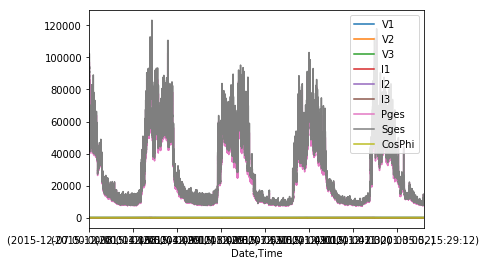

In [26]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
#def parser(x):
	#return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('/home/arun/Arun/notebooks/data/Torschlag_Trafo_07122015_to_11122015_new.csv', header=0, parse_dates=[0], index_col=[0,1], squeeze=True)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [32]:
# create a differenced series
import pandas as pd
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [33]:
raw_values = series.values
raw_values

array([[  2.33550000e+02,   2.32600000e+02,   2.32560000e+02, ...,
          8.71388900e+04,   9.27844600e+04,   9.30000000e-01],
       [  2.33400000e+02,   2.32490000e+02,   2.32450000e+02, ...,
          8.79209900e+04,   9.32484500e+04,   9.40000000e-01],
       [  2.33400000e+02,   2.32490000e+02,   2.32450000e+02, ...,
          8.79209900e+04,   9.32484500e+04,   9.40000000e-01],
       ..., 
       [  2.38350000e+02,   2.37900000e+02,   2.37840000e+02, ...,
          1.06733300e+04,   1.10624100e+04,   8.50000000e-01],
       [  2.38350000e+02,   2.37900000e+02,   2.37840000e+02, ...,
          1.06733300e+04,   1.10624100e+04,   8.50000000e-01],
       [  2.38350000e+02,   2.37900000e+02,   2.37840000e+02, ...,
          1.06733300e+04,   1.10624100e+04,   8.50000000e-01]])

In [34]:
diff_values = difference(raw_values, 1)

In [35]:
diff_values

0         [-0.15, -0.11, -0.11, 2.41, -1.69, 1.81, 782.1...
1             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4         [0.14, 0.2, 0.16, 3.2, -2.11, -0.28, 262.89, 2...
5             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
6             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
7             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8         [-0.26, -0.3, -0.25, -3.48, 1.99, 0.31, -324.6...
9             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
11            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
12        [0.33, 0.38, 0.31, 3.45, -1.32, 0.99, 765.0, 8...
13            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
14            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
15            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
16        [-0.19, -0.13, -0.19, -1.54, 2

In [36]:
diff_values[0]

array([ -1.50000000e-01,  -1.10000000e-01,  -1.10000000e-01,
         2.41000000e+00,  -1.69000000e+00,   1.81000000e+00,
         7.82100000e+02,   4.63990000e+02,   1.00000000e-02])